In [4]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
import gc
import scipy

from sklearn.preprocessing import LabelEncoder

In [5]:
# === df_train + df_valid ===
BASE_DIR = '/Users/zhaos/Downloads/archive'
RAW_DATA_DIR = os.path.join(BASE_DIR, 'raw_data')
TRAIN_CSV_PATH = os.path.join(RAW_DATA_DIR, 'cv-valid-train.csv')


datasets = ['cv-valid-train']
df_combined = []

for dataset in datasets:
    csv_file = os.path.join(BASE_DIR, f'{dataset}.csv')
    dftrain = pd.read_csv(csv_file)
    if (dataset == 'cv-valid-train'):
        dftrain = dftrain[dftrain['filename'] <= "cv-valid-train/sample-158122.mp3"]

    # Drop rows with missing gender
    dftrain = dftrain.dropna(subset=['gender'])

    # Drop rows with missing age
    dftrain = dftrain.dropna(subset=['age'])
    valid_ages = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties']
    dftrain = dftrain[dftrain['age'].isin(valid_ages)]
    
    dftrain = dftrain[dftrain['gender'].isin(['male', 'female'])]

    # Drop unused 'duration' column (100% NaN in some releases)
    if 'duration' in dftrain.columns:
        dftrain = dftrain.drop('duration', axis=1, errors='ignore')

    # Drop rows with missing accent
    dftrain = dftrain.dropna(subset=['accent'])
    valid_accents = ['england', 'indian', 'australia', 'scotland', 'us', 'ireland']
    dftrain = dftrain[dftrain['accent'].isin(valid_accents)]
    for index, row in dftrain.iterrows():
        dftrain.at[index, 'filename'] = os.path.join(dataset, row['filename'])
        if row['age'] in ['teen', 'twenties']:
            dftrain.at[index, 'age'] = 'youth'
        elif row['age'] in ['thirties', 'forties']:
            dftrain.at[index, 'age'] = 'adult'
        else:
            dftrain.at[index, 'age'] = 'middle-age'
    df_combined.append(dftrain)

dftrain = pd.concat(df_combined, ignore_index=True)

print(dftrain.value_counts('gender'))
print(dftrain['filename'].max())
dfbalanced = pd.concat([dftrain[dftrain['gender']=='male'][:10000], dftrain[dftrain['gender']=='female'][:10000]])

print(len(dftrain))

gender
male      31899
female    11225
Name: count, dtype: int64
cv-valid-train\cv-valid-train/sample-158120.mp3
43124


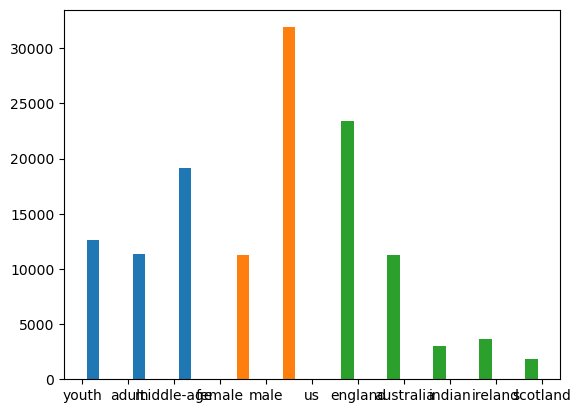

In [98]:
plt.hist((dftrain['age'], dftrain['gender'], dftrain['accent']))
plt.show()

In [6]:
label_encoder = LabelEncoder()
dfbalanced['gender'] = label_encoder.fit_transform(dfbalanced['gender'])
print(dfbalanced['gender'].value_counts())
print(label_encoder.classes_)

gender
1    10000
0    10000
Name: count, dtype: int64
['female' 'male']


In [5]:
import os
import librosa
import numpy as np
from tensorflow.keras.utils import to_categorical
import gc
from tqdm import tqdm

# Ensure RAW_DATA_DIR is defined (the folder containing your audio files)
# For example:
# RAW_DATA_DIR = '/path/to/your/audio/files'

def extract_mfcc(file_path, n_mfcc=20):
    audio, sr = librosa.load(file_path)
    win_length = int(0.025 * sr)   # 25ms window length
    hop_length = int(0.01 * sr)    # 10ms hop length
    n_fft = win_length           # Using window length as n_fft (can be adjusted)
    mfccs = librosa.feature.mfcc(
        y=audio,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window='hann'
    )
    return (audio, mfccs)

# === Process Training Data (df_balanced) ===
all_mfccs_train = []
audios = []
print("Extracting MFCCs for training set:")
for idx, row in tqdm(dfbalanced.iterrows(), total=len(dfbalanced), desc="Train MFCCs"):
    path = os.path.join(BASE_DIR, row['filename'])
    audio, mfcc = extract_mfcc(path)
    all_mfccs_train.append(mfcc)
    audios.append(audio)

# === Process Validation Data (df_valid) ===
'''all_mfccs_valid = []
print("Extracting MFCCs for validation set:")
for idx, row in tqdm(df_valid.iterrows(), total=len(df_valid), desc="Valid MFCCs"):
    path = os.path.join(RAW_DATA_DIR, row['filename'])
    mfcc = extract_mfcc(path)
    all_mfccs_valid.append(mfcc)

# === Process Test Data (df_test) ===
all_mfccs_test = []
print("Extracting MFCCs for test set:")
for idx, row in tqdm(df_test.iterrows(), total=len(df_test), desc="Test MFCCs"):
    path = os.path.join(RAW_DATA_DIR, row['filename'])
    mfcc = extract_mfcc(path)
    all_mfccs_test.append(mfcc)'''

gc.collect()


gc.collect()


Extracting MFCCs for training set:


Train MFCCs:  70%|███████████████████████████████████████████▉                   | 13929/20000 [06:16<02:43, 37.04it/s]


KeyboardInterrupt: 

In [12]:
import pickle

with open('all_mfccs.pickle', 'wb') as f:
    pickle.dump(all_mfccs_train, f)

In [7]:
import pickle

with open('all_mfccs.pickle', 'rb') as f:
    all_mfccs_train = pickle.load(f)

<function matplotlib.pyplot.show(close=None, block=None)>

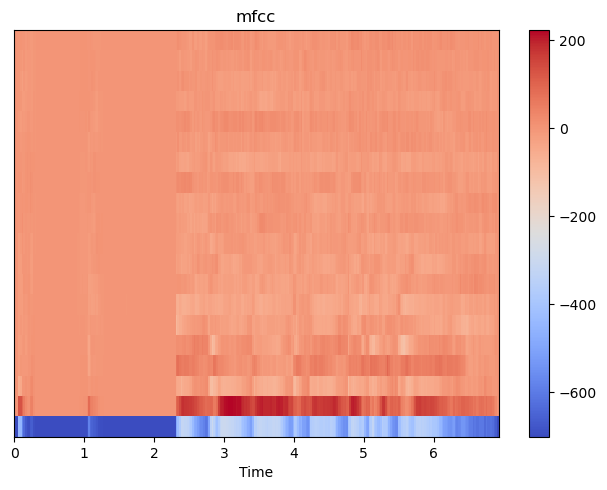

In [92]:
librosa.display.specshow(all_mfccs_train[1000], x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('mfcc')
plt.show

In [8]:
time_frames_train = [mfcc.shape[1] for mfcc in all_mfccs_train]
all_time_frames = time_frames_train
median_time_frames = int(np.median(all_time_frames))
print("Median time frames (train+valid):", median_time_frames)

# Pad or truncate MFCCs to have the same number of time frames (equal to the median)
def pad_or_truncate(mfcc, target_length):
    if mfcc.shape[1] < target_length:
        padded = np.pad(mfcc, ((0, 0), (0, target_length - mfcc.shape[1])), mode='constant')
    else:
        padded = mfcc[:, :target_length]
    return padded

padded_mfccs_train = [pad_or_truncate(mfcc, median_time_frames) for mfcc in all_mfccs_train]

Median time frames (train+valid): 378


In [9]:
mfcc_stats = []
all_mfccs = padded_mfccs_train
for i in range(len(all_mfccs)):
    stats = []
    mfcc_data = all_mfccs[i]
    if (i % 100) == 0:
        print(f"Processing {i}th mfcc")
    for j in range(mfcc_data.shape[0]):
        x = mfcc_data[j, :]
        mean = np.mean(x)
        std = np.std(x)
        maxv = np.amax(x)
        minv = np.amin(x)
        median = np.median(x)
        skew = scipy.stats.skew(x)
        kurt = scipy.stats.kurtosis(x)
        q1 = np.quantile(x, 0.25)
        q3 = np.quantile(x, 0.75)
        iqr = scipy.stats.iqr(x)
        stats.extend([mean, std, maxv, minv, median, skew, kurt, q1, q3, iqr])
    mfcc_stats.append(stats)

Processing 0th mfcc
Processing 100th mfcc
Processing 200th mfcc
Processing 300th mfcc
Processing 400th mfcc
Processing 500th mfcc
Processing 600th mfcc
Processing 700th mfcc
Processing 800th mfcc
Processing 900th mfcc
Processing 1000th mfcc
Processing 1100th mfcc
Processing 1200th mfcc
Processing 1300th mfcc
Processing 1400th mfcc
Processing 1500th mfcc
Processing 1600th mfcc
Processing 1700th mfcc
Processing 1800th mfcc
Processing 1900th mfcc
Processing 2000th mfcc
Processing 2100th mfcc
Processing 2200th mfcc
Processing 2300th mfcc
Processing 2400th mfcc
Processing 2500th mfcc
Processing 2600th mfcc
Processing 2700th mfcc
Processing 2800th mfcc
Processing 2900th mfcc
Processing 3000th mfcc
Processing 3100th mfcc
Processing 3200th mfcc
Processing 3300th mfcc
Processing 3400th mfcc
Processing 3500th mfcc
Processing 3600th mfcc
Processing 3700th mfcc
Processing 3800th mfcc
Processing 3900th mfcc
Processing 4000th mfcc
Processing 4100th mfcc
Processing 4200th mfcc
Processing 4300th mfcc


In [10]:
x = mfcc_stats
y = dfbalanced['gender']

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True)

In [17]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score

model_performance = {}
model_performance['KNN'] = 0
model_performance['SVM'] = 0
model_performance['Random Forest'] = 0
model_performance['XGBoost'] = 0

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)
for i, (train_index, validate_index) in enumerate(skf.split(X_train, y_train)):
    print(i)
    x_train_split = np.array([X_train[i] for i in train_index])
    y_train_split = np.array([y_train.iloc[i] for i in train_index])
    x_valid_split = np.array([X_train[i] for i in validate_index])
    y_valid_split = np.array([y_train.iloc[i] for i in validate_index])

    print("Training KNN")
    knn = KNeighborsClassifier(n_neighbors=5)
    p_grid = {"n_neighbors": [5, 10, 50, 100]}
    clf = GridSearchCV(estimator=knn, param_grid=p_grid, cv = StratifiedKFold(n_splits=5, shuffle = True))
    clf.fit(x_train_split, y_train_split)
    y_pred_knn = clf.predict(x_valid_split)
    acc_knn = accuracy_score(y_valid_split, y_pred_knn)
    model_performance['KNN'] += acc_knn

    print("Training SVM")
    svm = SVC(kernel='rbf', C=1.0, random_state=42)
    p_grid = {"C": [1, 1.5, 2, 5, 10]}
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv = StratifiedKFold(n_splits=5, shuffle = True))
    clf.fit(x_train_split, y_train_split)
    y_pred_svm = clf.predict(x_valid_split)
    acc_svm = accuracy_score(y_valid_split, y_pred_svm)
    model_performance['SVM'] += acc_svm

    print("Training Random Forest")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    p_grid = {"max_depth": [10, 20, 30, 40, 50], "min_samples_split": [2, 3, 4, 5, 6]}
    clf = GridSearchCV(estimator=rf, param_grid=p_grid, cv = StratifiedKFold(n_splits=5, shuffle = True))
    clf.fit(x_train_split, y_train_split)
    y_pred_rf = clf.predict(x_valid_split)
    acc_rf = accuracy_score(y_valid_split, y_pred_rf)
    model_performance['Random Forest'] += acc_rf

    xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1,
                            random_state=42,
                            eval_metric='mlogloss')
    xgb_clf.fit(x_train_split, y_train_split)
    y_pred_xgb = xgb_clf.predict(x_valid_split)
    acc_xgb = accuracy_score(y_valid_split, y_pred_xgb)
    model_performance['XGBoost'] += acc_xgb
print(model_performance)

0
Training KNN
Training SVM
Training Random Forest
1
Training KNN
Training SVM
Training Random Forest
2
Training KNN
Training SVM
Training Random Forest
3
Training KNN
Training SVM
Training Random Forest
4
Training KNN
Training SVM
Training Random Forest
{'KNN': 4.202916666666667, 'SVM': 4.391666666666667, 'Random Forest': 4.46375, 'XGBoost': 4.571666666666666}


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
xgb_clf = xgb.XGBClassifier(n_estimators=10000, learning_rate=0.1,
                            random_state=42,
                            eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4002
           1       0.94      0.93      0.94      3998

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000

[[3773  229]
 [ 270 3728]]


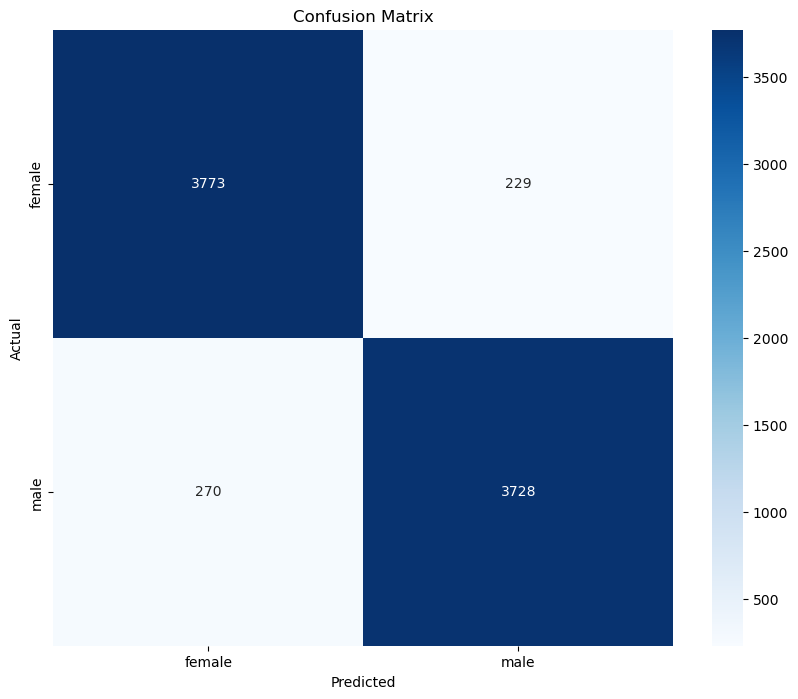

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d', xticklabels=['female', 'male'], yticklabels=['female', 'male'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()